In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torchvision

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
max_epochs = 150
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.scripts.detection.coco_utils import get_coco
from pathlib import Path

COCO_ROOT = Path(DATA_ROOT).expanduser() / "coco"
is_train = False
image_set = "train" if is_train else "val"
num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[
    "coco"
]
with_masks = True
ds = get_coco(
    root=COCO_ROOT,
    image_set=image_set,
    transforms=None,
    mode=mode,
    use_v2=False,
    with_masks=with_masks,
)
data_idx = 6

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


## Original Data

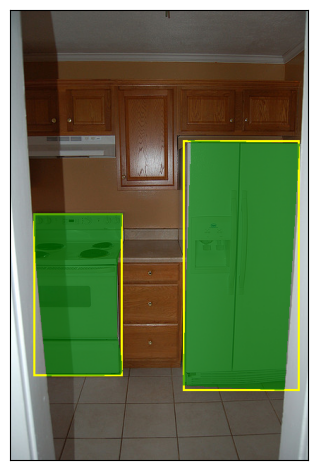

In [3]:
from hdd.visualization.vis_utils import det_seg_plot

original_image, original_target = ds[data_idx]
det_seg_plot([(original_image, original_target)])

## RandomHorizontalFlip

Orig Image Shape:  (424, 640)
HFlip Image Shape:  (424, 640)


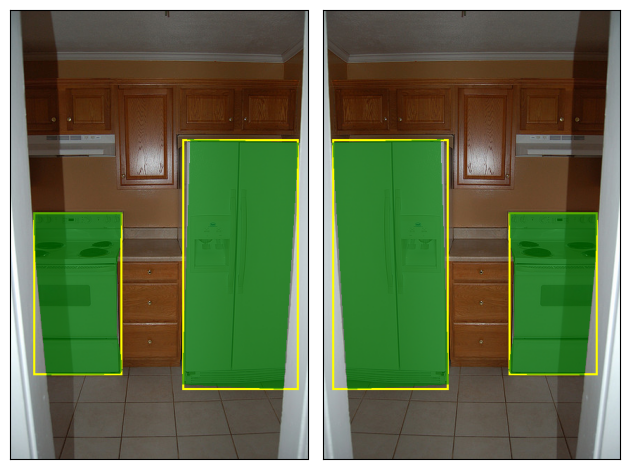

In [4]:
import hdd.scripts.detection.transforms as T

torch.manual_seed(36)
random_flip = T.RandomHorizontalFlip(0.5)
image, target = ds[data_idx]
hflip_image, hflip_target = random_flip(image, target)
print("Orig Image Shape: ", original_image.size)
print("HFlip Image Shape: ", hflip_image.size)
det_seg_plot([(original_image, original_target), (hflip_image, hflip_target)])

## RandomIoUCrop

Orig Image Shape:  (424, 640)
IOU Image Shape:  (256, 197)


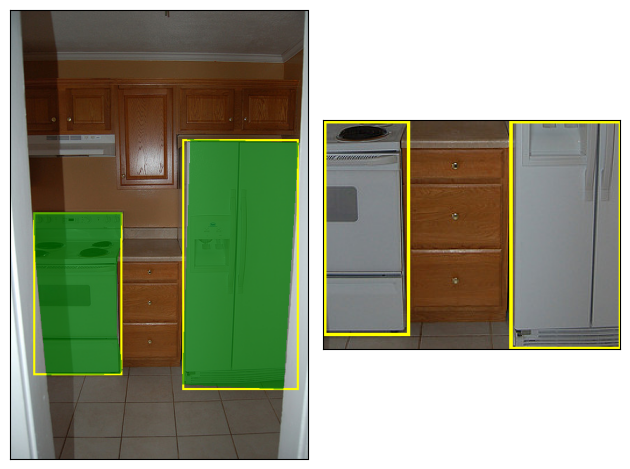

In [5]:
random_iou_crop = T.RandomIoUCrop(
    min_scale=0.3,
    max_scale=1.0,
    min_aspect_ratio=0.5,
    max_aspect_ratio=2.0,
)
torch.manual_seed(36)
image, target = ds[data_idx]
iou_crop_image, iou_crop_target = random_iou_crop(image, target)
del iou_crop_target["masks"]
print("Orig Image Shape: ", original_image.size)
print("IOU Image Shape: ", iou_crop_image.size)
det_seg_plot([(original_image, original_target), (iou_crop_image, iou_crop_target)])

## RandomZoomOut

Orig Image Shape:  (424, 640)
Zoomed Image Shape:  (1257, 1898)


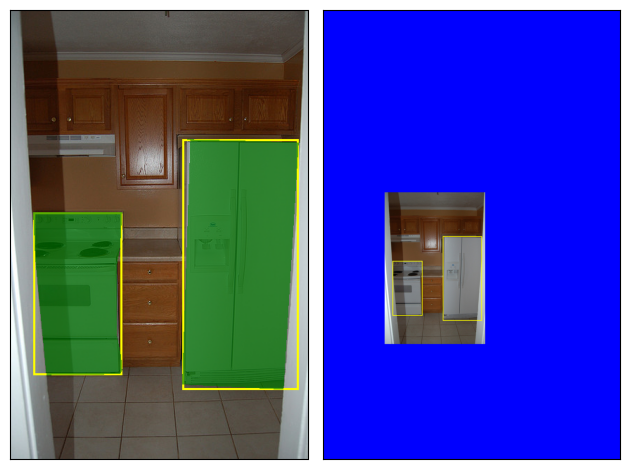

In [6]:
BLUE = (0, 0, 255)
random_iou_crop = T.RandomZoomOut(fill=(0, 0, 255), side_range=(2.0, 4.0), p=0.9)
torch.manual_seed(10)
image, target = ds[data_idx]
zoom_out_image, zoom_out_target = random_iou_crop(image, target)
del zoom_out_target["masks"]
print("Orig Image Shape: ", original_image.size)
print("Zoomed Image Shape: ", zoom_out_image.size)
det_seg_plot([(original_image, original_target), (zoom_out_image, zoom_out_target)])

## RandomPhotometricDistort

Orig Image Shape:  (424, 640)
Distorted Image Shape:  (424, 640)


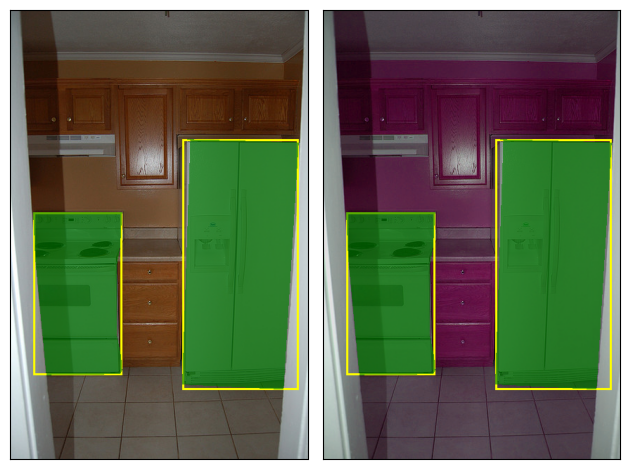

In [7]:
photometric_distort = T.RandomPhotometricDistort(p=0.5)
torch.manual_seed(13)
image, target = ds[data_idx]
distorted_image, distorted_target = photometric_distort(image, target)
print("Orig Image Shape: ", original_image.size)
print("Distorted Image Shape: ", distorted_image.size)
det_seg_plot([(original_image, original_target), (distorted_image, distorted_target)])

## ScaleJitter

Orig Image Shape:  (424, 640)
Jittered Image Shape:  (145, 218)


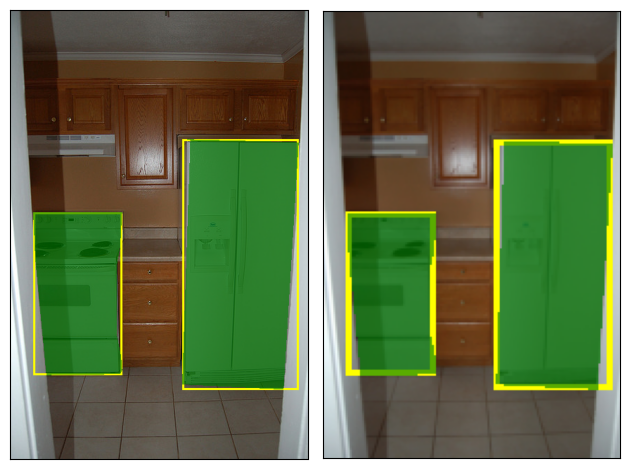

In [8]:
scale_jitter = T.ScaleJitter(target_size=(512, 1024), scale_range=(0.1, 0.5))
torch.manual_seed(10)
image, target = ds[data_idx]
jittered_image, jittered_target = scale_jitter(image, target)

print("Orig Image Shape: ", original_image.size)
print("Jittered Image Shape: ", jittered_image.size)
det_seg_plot([(original_image, original_target), (jittered_image, jittered_target)])

## FixedSizeCrop

Orig Image Shape:  (424, 640)
Cropped Image Shape:  (256, 328)


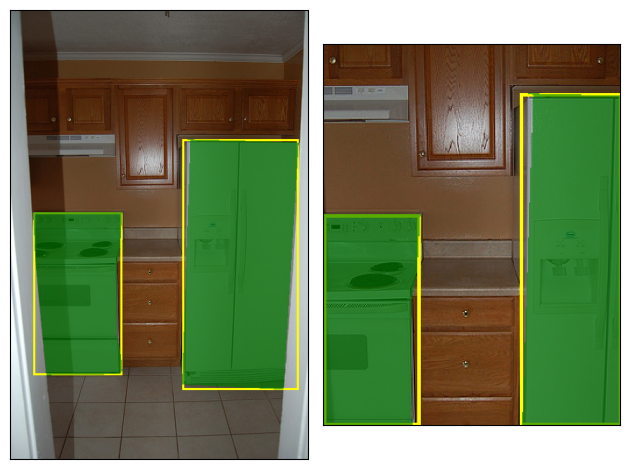

In [9]:
fixed_size_crop = T.FixedSizeCrop(size=(328, 256))
image, target = ds[data_idx]
torch.manual_seed(10)
cropped_image, cropped_target = fixed_size_crop(image, target)

print("Orig Image Shape: ", original_image.size)
print("Cropped Image Shape: ", cropped_image.size)
det_seg_plot([(original_image, original_target), (cropped_image, cropped_target)])

Orig Image Shape:  (424, 640)
Cropped Image Shape:  (512, 320)


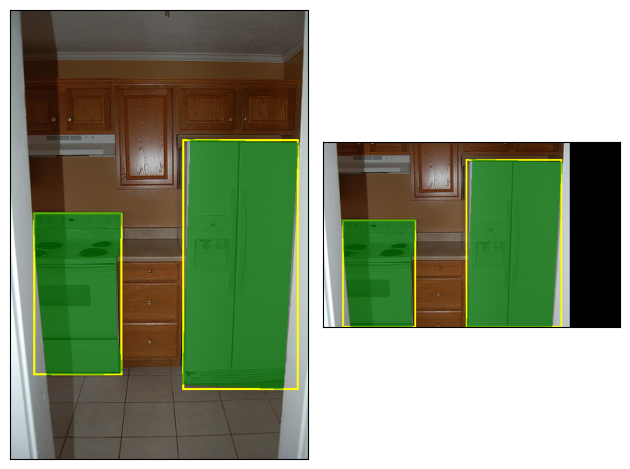

In [10]:
fixed_size_crop = T.FixedSizeCrop(size=(320, 512))
image, target = ds[data_idx]
cropped_image, cropped_target = fixed_size_crop(image, target)
print("Orig Image Shape: ", original_image.size)
print("Cropped Image Shape: ", cropped_image.size)
det_seg_plot([(original_image, original_target), (cropped_image, cropped_target)])

## RandomShortestSize

Orig Image Shape:  (424, 640)
Cropped Image Shape:  (256, 386)


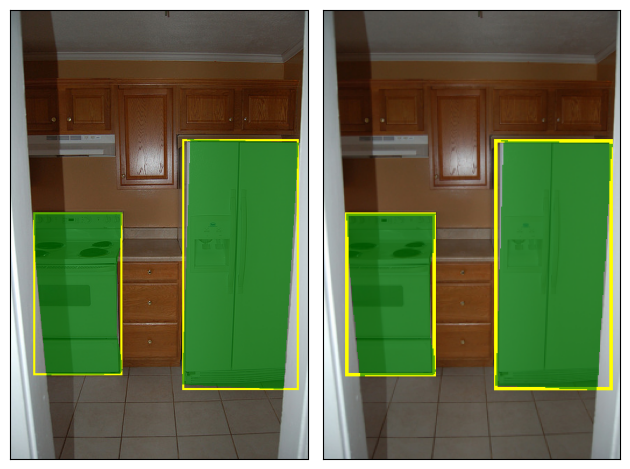

In [17]:
random_short_size = T.RandomShortestSize(min_size=256, max_size=512)
image, target = ds[data_idx]
torch.manual_seed(10)
new_image, new_target = random_short_size(image, target)

print("Orig Image Shape: ", original_image.size)
print("Cropped Image Shape: ", new_image.size)
det_seg_plot([(original_image, original_target), (new_image, new_target)])

## SimpleCopyPaste


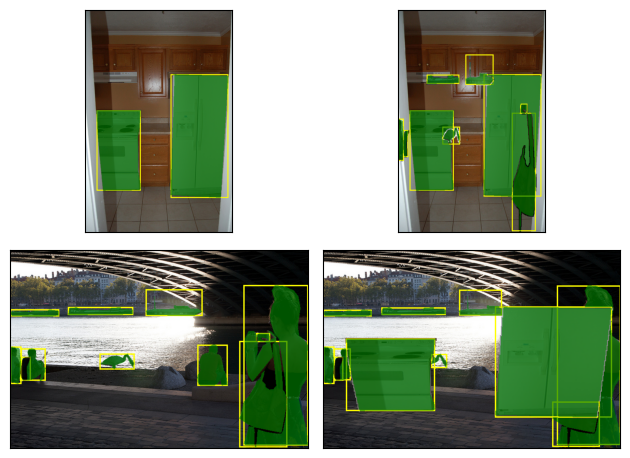

In [31]:
from torchvision.transforms.functional import to_pil_image

simple_copy_paste = T.SimpleCopyPaste()
pil_to_tensor = T.PILToTensor()
image1, target1 = pil_to_tensor(*ds[data_idx])
image2, target2 = pil_to_tensor(*ds[data_idx + 4])
original_image_2, original_target_2 = ds[data_idx + 4]
torch.manual_seed(12)
new_images, new_targets = simple_copy_paste([image1, image2], [target1, target2])

det_seg_plot(
    [
        [
            (original_image, original_target),
            (to_pil_image(new_images[0]), new_targets[0]),
        ],
        [
            (original_image_2, original_target_2),
            (to_pil_image(new_images[1]), new_targets[1]),
        ],
    ]
)